# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [5]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

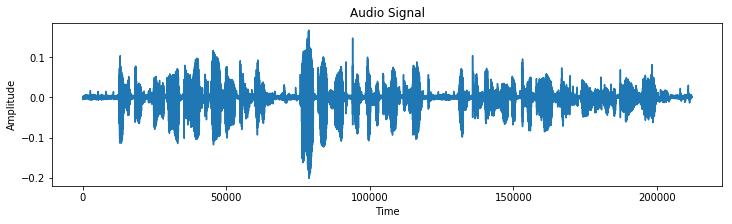

**Shape of Audio Signal** : (212121,)

**Transcript** : instantly they absorbed all my attention though i dared not give them a direct look and continued to observe them only in the glass

In [6]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

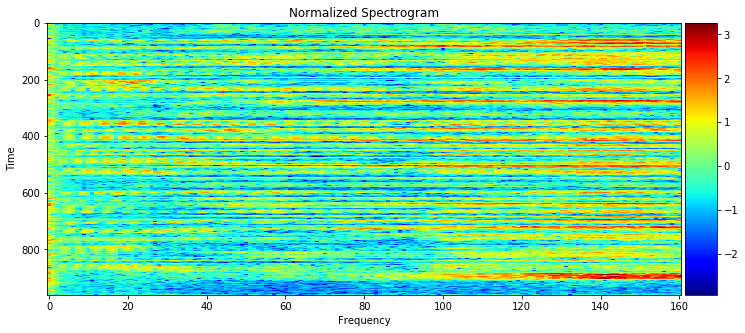

**Shape of Spectrogram** : (961, 161)

In [6]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

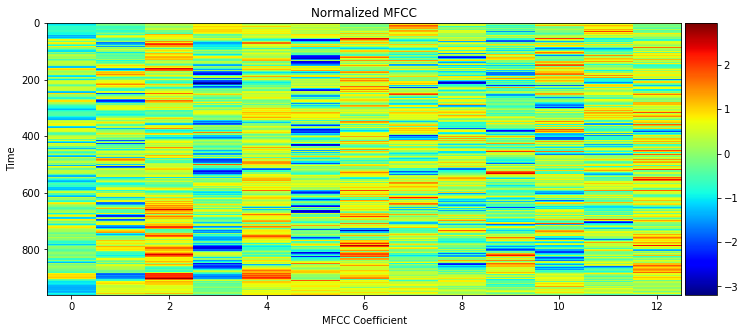

**Shape of MFCC** : (961, 13)

In [7]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.
c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3141912469399460012, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5153960755
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15649262892979429675
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [2]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [3]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
106/106 [==============================] - 194s - loss: 835.3197 - val_loss: 728.3093
Epoch 2/20
106/106 [==============================] - 192s - loss: 752.2535 - val_loss: 727.3337
Epoch 3/20
106/106 [==============================] - 193s - loss: 751.6808 - val_loss: 724.0550
Epoch 4/20
106/106 [==============================] - 192s - loss: 751.2464 - val_loss: 727.0930
Epoch 5/20
106/106 [==============================] - 191s - loss: 751.2815 - val_loss: 730.3658
Epoch 6/20
106/106 [==============================] - 190s - loss: 751.7474 - val_loss: 720.0205
Epoch 7/20
106/106 [==============================] - 191s - loss: 751.2271 - val_loss: 722.9005
Epoch 8/20
106/106 [==============================] - 191s - loss: 751.6734 - val_loss: 735.1518
Epoch 9/20
106/106 [==============================] - 191s - loss: 752.1374 - val_loss: 732.4842
Epoch 10/20
106/106 [==============================] -

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [14]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [15]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
106/106 [==============================] - 209s - loss: 286.1038 - val_loss: 268.6935
Epoch 2/20
106/106 [==============================] - 199s - loss: 203.7129 - val_loss: 192.1071
Epoch 3/20
106/106 [==============================] - 197s - loss: 183.2222 - val_loss: 184.7434
Epoch 4/20
106/106 [==============================] - 198s - loss: 168.4017 - val_loss: 164.4407
Epoch 5/20
106/106 [==============================] - 197s - loss: 155.3321 - val_loss: 158.5986
Epoch 6/20
106/106 [==============================] - 196s - loss: 148.0942 - val_loss: 151.6139
Epoch 7/20
106/106 [==============================] - 196s - loss: 142.8548 - val_loss: 144.1143
Epoch 8/20
106/106 [==============================] - 197s - loss: 139.3915 - val_loss: 144.7985
Epoch 9/20
106/106 [==============================] - 196s - loss: 136.0950 - val_loss: 140.5295
Epoch 10/20
106/106 [==============================] -

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [16]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [17]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True,  # change to False if you would like to use MFCC features
            early=True,
            patience=3) 

Epoch 1/20
106/106 [==============================] - 106s - loss: 237.4430 - val_loss: 209.4671
Epoch 2/20
106/106 [==============================] - 53s - loss: 182.4416 - val_loss: 170.8940
Epoch 3/20
106/106 [==============================] - 53s - loss: 153.9789 - val_loss: 152.6719
Epoch 4/20
106/106 [==============================] - 50s - loss: 140.7189 - val_loss: 142.4685
Epoch 5/20
106/106 [==============================] - 50s - loss: 132.0383 - val_loss: 141.0099
Epoch 6/20
106/106 [==============================] - 50s - loss: 125.1522 - val_loss: 134.2492
Epoch 7/20
106/106 [==============================] - 50s - loss: 119.7905 - val_loss: 134.9253
Epoch 8/20
106/106 [==============================] - 49s - loss: 115.0637 - val_loss: 135.4775
Epoch 9/20
106/106 [==============================] - 49s - loss: 110.6749 - val_loss: 131.2142
Epoch 10/20
106/106 [==============================] - 48s - loss: 107.2709 - val_loss: 133.8983
Epoch 11/20
106/106 [=================

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [21]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         activation='relu',
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn-0 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn-1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [22]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True,  # change to False if you would like to use MFCC features
            early=True,
            patience=3) 

Epoch 1/20
106/106 [==============================] - 351s - loss: 376.3848 - val_loss: 282.5920
Epoch 2/20
106/106 [==============================] - 352s - loss: 230.8310 - val_loss: 206.5974
Epoch 3/20
106/106 [==============================] - 351s - loss: 196.8587 - val_loss: 182.2309
Epoch 4/20
106/106 [==============================] - 352s - loss: 171.5754 - val_loss: 165.2907
Epoch 5/20
106/106 [==============================] - 353s - loss: 152.6625 - val_loss: 157.5544
Epoch 6/20
106/106 [==============================] - 352s - loss: 142.1764 - val_loss: 145.8099
Epoch 7/20
106/106 [==============================] - 352s - loss: 134.3921 - val_loss: 143.0545
Epoch 8/20
106/106 [==============================] - 350s - loss: 128.6262 - val_loss: 136.8194
Epoch 9/20
106/106 [==============================] - 352s - loss: 124.4157 - val_loss: 137.2065
Epoch 10/20
106/106 [==============================] - 351s - loss: 120.8655 - val_loss: 133.4066
Epoch 11/20
106/106 [========

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [2]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  activation='relu')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True,  # change to False if you would like to use MFCC features
            early=True,
            patience=3) 

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
106/106 [==============================] - 324s - loss: 415.2707 - val_loss: 390.0798
Epoch 2/20
106/106 [==============================] - 322s - loss: 356.1683 - val_loss: 358.6025
Epoch 3/20
106/106 [==============================] - 322s - loss: 247.6877 - val_loss: 201.4503
Epoch 4/20
106/106 [==============================] - 320s - loss: 203.8608 - val_loss: 190.4766
Epoch 5/20
106/106 [==============================] - 318s - loss: 190.8836 - val_loss: 182.6860
Epoch 6/20
106/106 [==============================] - 316s - loss: 181.3472 - val_loss: 178.4925
Epoch 7/20
106/106 [==============================] - 317s - loss: 173.2020 - val_loss: 167.3108
Epoch 8/20
106/106 [==============================] - 319s - loss: 166.4041 - val_loss: 165.5406
Epoch 9/20
106/106 [==============================] - 316s - loss: 159.9069 - val_loss: 162.3927
Epoch 10/20
106/106 [==============================] -

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [ ]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

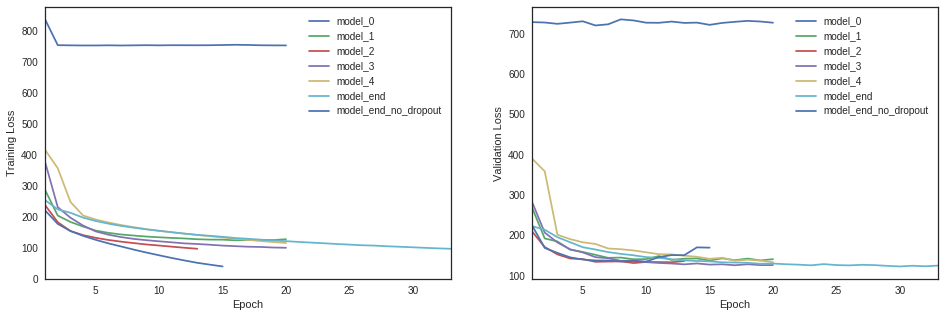

In [9]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ 
 * Model 0 (simple_rnn): The validation loss is margianlly higher than any other model and seems to be stagnating right from the beginning. The same thing can be said for the training loss. That is because it doesn't have enough trainable parameters (ergo learning capacity) to learn the complex function that is needed to transform Spectrogram into graphemes.
 * Model 1 (rnn): This model seems to be doing pretty well, but it's validation and training losses start to stagnate at around 10 epochs. The reason is the same as with the Model 0, not enough trainable parameters.
 * Model 2 (cnn_rnn): The convolution layer allows the model to learn how to extract important features from the spectrogram and at the same time reduce the training times because the extracted features have smaller size than the spectrogram itself, which means that the following RNN has smaller unroll size (temporal size).
 * Model 3 (deep_rnn): The best model regarding validation loss seems to be model 3 (Deep RNN model with 2 GRU recurrent layers). Based on the trend of the validation loss, it might be possible to get even lower validation loss by running more training epochs.
 * Model_4 (bidirectional_rnn): BRNN seems to have slow training start but the trend of validation loss after 20 epochs seems to be more steep than with the rest of the models so. Providing more traning epochs, this model seems to trend towards the lowest validation loss.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
# specify the model
model_end = final_model(input_dim=13,
                        conv_layers=2,
                        filters=32,
                        kernel_size=16, 
                        pooling_size=2,
                        conv_stride=1,
                        conv_border_mode='causal',
                        units=64,
                        activation='tanh',
                        recur_layers=2,
                        dropout_w=0.3,
                        dropout_u=0.1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d-0 (Conv1D)            (None, None, 32)          6688      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d-1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 32)          128    

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False,  # change to False if you would like to use MFCC features
            epochs=40,
            early=True,
            patience=3) 

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/40


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d-0/convolution/Conv2D (defined at c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\keras\backend\tensorflow_backend.py:3098)  = Conv2D[T=DT_FLOAT, _class=["loc:@gradients/conv1d-0/convolution/Conv2D_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/conv1d-0/convolution/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d-0/convolution/ExpandDims_1)]]
	 [[{{node ctc/scan/while/ExpandDims/_83}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1197_ctc/scan/while/ExpandDims", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_cloopctc/scan/while/TensorArrayReadV3/_1)]]

Caused by op 'conv1d-0/convolution/Conv2D', defined at:
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\ioloop.py", line 605, in _run_callback
    ret = callback()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 1152, in inner
    self.run()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 319, in wrapper
    _futures_to_runners[future] = Runner(result, future, yielded)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 1003, in __init__
    self.run()
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 307, in wrapper
    yielded = next(result)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 307, in wrapper
    yielded = next(result)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tornado\gen.py", line 307, in wrapper
    yielded = next(result)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-a4c82c56d4ee>", line 13, in <module>
    dropout_u=0.1)
  File "d:\!private\Lord\Git\AIND-VUI-Capstone\sample_models.py", line 163, in final_model
    input_data)
  File "d:\!private\Lord\Git\AIND-VUI-Capstone\sample_models.py", line 143, in batch_norm
    output = cur_layer(inp_layer)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\keras\engine\topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\keras\layers\convolutional.py", line 156, in call
    dilation_rate=self.dilation_rate[0])
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\keras\backend\tensorflow_backend.py", line 3098, in conv1d
    data_format=tf_data_format)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 193, in _conv1d
    name=name)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\util\deprecation.py", line 553, in new_func
    return func(*args, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\util\deprecation.py", line 553, in new_func
    return func(*args, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2471, in conv1d
    data_format=data_format)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1d-0/convolution/Conv2D (defined at c:\users\martin\appdata\local\continuum\anaconda3\envs\speech-recognition\lib\site-packages\keras\backend\tensorflow_backend.py:3098)  = Conv2D[T=DT_FLOAT, _class=["loc:@gradients/conv1d-0/convolution/Conv2D_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/conv1d-0/convolution/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d-0/convolution/ExpandDims_1)]]
	 [[{{node ctc/scan/while/ExpandDims/_83}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1197_ctc/scan/while/ExpandDims", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_cloopctc/scan/while/TensorArrayReadV3/_1)]]


__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [14]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [17]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161,
                                            conv_layers=4,
                                            filters=256,
                                            kernel_size=12, 
                                            conv_stride=1,
                                            conv_border_mode='causal',
                                            units=256,
                                            activation='relu',
                                            recur_layers=2,
                                            dropout_w=0.0,
                                            dropout_u=0.0), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d-0 (Conv1D)            (None, None, 256)         494848    
_________________________________________________________________
conv1d-1 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
conv1d-2 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
conv1d-3 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
birnn-0 (Bidirectional)      (None, None, 512)         787968    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 512)         2048      
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [ ]:
final_model_inference = final_model(input_dim=161,
                                    conv_layers=4,
                                    filters=256,
                                    kernel_size=12, 
                                    conv_stride=1,
                                    conv_border_mode='causal',
                                    units=256,
                                    activation='relu',
                                    recur_layers=2,
                                    dropout_w=0.0,
                                    dropout_u=0.0)

In [18]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=161,
                                            conv_layers=4,
                                            filters=256,
                                            kernel_size=12, 
                                            conv_stride=1,
                                            conv_border_mode='causal',
                                            units=256,
                                            activation='relu',
                                            recur_layers=2,
                                            dropout_w=0.0,
                                            dropout_u=0.0), 
                model_path='./results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d-0 (Conv1D)            (None, None, 256)         494848    
_________________________________________________________________
conv1d-1 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
conv1d-2 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
conv1d-3 (Conv1D)            (None, None, 256)         786688    
_________________________________________________________________
birnn-0 (Bidirectional)      (None, None, 512)         787968    
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 512)         2048      
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!